# TODO : 
- [ ] understand what's going on with covariance matrices
- [ ] understand how to better use patches 
- [ ] write preliminary results with cov = shot_noise 
- [ ] are the three samples independant ?

In [2]:
import numpy as np
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from matplotlib import pyplot as plt
from astropy.io import ascii
import GCRCatalogs
from GCR import GCRQuery
import healpy
import astropy.units as u
import pandas as pd
import matplotlib
from magnification_library import *
import pyccl
#from clmm import modeling as mod
from scipy.optimize import curve_fit
from scipy import stats

In [3]:
pyccl.__version__

'2.1.0'

In [4]:
matplotlib.rcParams.update({'font.size': 14})

In [5]:
#extragalactic_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

In [6]:
#cosmo = extragalactic_cat.cosmology

In [7]:
#define cosmology
#params = {'flat': True, 'H0': 71., 'Om0': 0.2648, 'Ob0': 0.0448, 'sigma8': 0.80, 'ns': 0.963}

#astropy object
cosmo = FlatLambdaCDM(H0=71, Om0=0.265, Tcmb0=0 , Neff=3.04, m_nu=None, Ob0=0.0448)

#ccl object
cosmo_ccl = pyccl.Cosmology(Omega_c=cosmo.Om0-cosmo.Ob0, Omega_b=cosmo.Ob0,
                      h=cosmo.h, sigma8= 0.80, n_s=0.963)

In [8]:
def Mpc_to_arcmin(x_Mpc, z, cosmo=cosmo):
    return x_Mpc * cosmo.arcsec_per_kpc_proper(z).to(u.arcmin/u.Mpc).value

def arcmin_to_Mpc(x_arc, z, cosmo=cosmo):
    return x_arc * cosmo.kpc_proper_per_arcmin(z).to(u.Mpc/u.arcmin).value 

In [9]:
def corr_plot(r, xi, sigxi, r_rand, xi_rand, sigxi_rand, fig=None, ax=None, corr=False):
    if fig==None:
        fig, ax = plt.subplots(1,1)
    
    if corr==True:
        sigxi = np.sqrt(np.diag(sigxi))
        sigxi_rand = np.sqrt(np.diag(sigxi_rand))
    
    ax.errorbar(r, xi, yerr= sigxi, color='red', fmt='o')
    ax.fill_between(r_rand, y1= xi_rand - sigxi_rand, y2 = xi_rand + sigxi_rand, color='grey',alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel(r'$\theta$ (arcmin)')
    ax.set_ylabel(r'$\delta_{\mu}$')
    return fig, ax

## Open data

In [22]:
path_file = '../'

In [23]:
key = 'LBGp'

gal_cat =  pd.read_hdf(path_file+'input_data/cat_'+key+'.h5', key=key)
dat = np.load(path_file+"input_data/source_sample_properties.npy", allow_pickle=True)
mag_cut, alpha_cut, mag_null = dat[np.where(dat[:,0]==key)][0][1:]

In [24]:
selection_source = ( gal_cat['ra']>50) & ( gal_cat['ra']<73.1) & ( gal_cat['dec']<-27.) & ( gal_cat['dec']>-45.)
selection = selection_source * (gal_cat['mag_i_lsst']<mag_cut) * (gal_cat['redshift']>1.5)

In [25]:
quant = np.load(path_file + "output_data/binned_correleation_fct_"+key+".npy", allow_pickle=True)

In [27]:
[z_cl, mass_cl, n_halo] = np.load(path_file + "output_data/halo_bin_properties.npy", allow_pickle=True)

# **Compute model of magnfication biais**

### - Concentration mass relation 

In [28]:
def get_halo_concentration(mass_lens, z_lens, cosmo, cosmo_ccl, relation="Diemer15"):
    mdef = pyccl.halos.massdef.MassDef(200, 'critical', c_m_relation=relation)
    concdef = pyccl.halos.concentration.concentration_from_name(relation)()
    conc = concdef.get_concentration(cosmo=cosmo_ccl, M=mass_lens, a=cosmo.scale_factor(z_lens), mdef_other=mdef)
    return conc 

In [29]:
conc = np.zeros((5,5))
for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        conc[i,j] = get_halo_concentration(mass_cl[i,j], z_cl[i,j], cosmo, cosmo_ccl, "Diemer15")

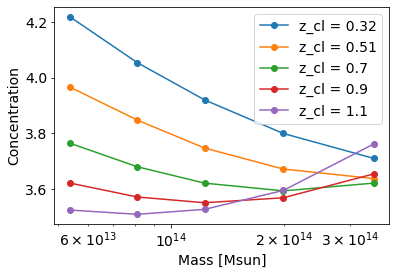

In [30]:
for i in range(len(z_cl)):
    plt.plot(mass_cl[0,:], conc[i,:], 'o-',  label = 'z_cl = '+str(np.round(z_cl[i,0],2)))
             
plt.xscale('log')

plt.legend()
plt.xlabel("Mass [Msun]")
plt.ylabel('Concentration');

### -  Modelisation of the source redshift distribution

Text(0, 0.5, 'pdf')

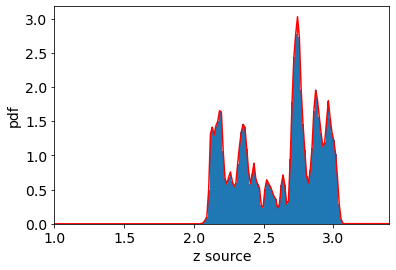

In [31]:
hist = plt.hist(gal_cat['redshift'][selection], bins=100, range=[1.8,3.1], density=True, stacked=True);
pdf_zsource = zpdf_from_hist(hist, zmin=0, zmax=10)
plt.plot(pdf_zsource.x, pdf_zsource.y, 'r')
plt.xlim(1,3.4)

plt.xlabel('z source')
plt.ylabel('pdf')

In [32]:
zint = np.linspace(0, 3.5, 1000)

In [33]:
zrand = np.random.choice(zint, 1000, p=pdf_zsource(zint)/np.sum(pdf_zsource(zint)))

In [34]:
print(zrand.mean())

2.6048478478478483


### - Model for the magnification biais

In [140]:
def magnification_biais_model(rproj, mass_lens, z_lens, alpha, z_source, cosmo, cosmo_ccl):
    
    conc = get_halo_concentration(mass_lens, z_lens, cosmo, cosmo_ccl)
    magnification = np.zeros(len(rproj))
    for k in range(len(rproj)):

        magnification[k] = np.mean(mod.predict_magnification(rproj[k]*cosmo.h, mdelta=mass_lens*cosmo.h, cdelta=conc, 
                                        z_cluster=z_lens, z_source=z_source, cosmo=cosmo, 
                                        delta_mdef=200, 
                                        halo_profile_model='NFW', 
                                        z_src_model='single_plane'))

        
    model = mu_bias(magnification, alpha) - 1. 
    
    return model
    

In [141]:
rp = np.logspace(-2, 1, 100)

In [142]:
#model with the full redshift distribution

model = np.zeros((rp.size, len(z_cl), len(mass_cl)))
for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        model[:,i,j] = magnification_biais_model(rp, mass_cl[i,j], z_cl[i,j], alpha_cut, zrand, cosmo, cosmo_ccl)

/pbs/throng/lsst/users/mricci/desc/Magnification_project/magnification_library.py:92: RuntimeWarning: invalid value encountered in power
  mu_bias = mu**(beta-1)


In [145]:
#model with approximate mean redshift and source plane approximation

model2 = np.zeros((rp.size, len(z_cl), len(mass_cl)))
for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        model2[:,i,j] = magnification_biais_model(rp, mass_cl[i,j], z_cl[i,j], alpha_cut, 2.7, cosmo, cosmo_ccl)

#model with approximate mean redshift and source plane approximation

models2 = np.zeros((rp.size, len(z_cl), len(mass_cl)))
for i in np.arange(z_cl.shape[0]):
    for j in np.arange(mass_cl.shape[1]):
        models2[:,i,j] = shear_model(rp, mass_cl[i,j], z_cl[i,j], alpha_cut, 2.7, cosmo, cosmo_ccl)

Text(0, 0.5, '$\\Delta (\\delta$($\\theta$)')

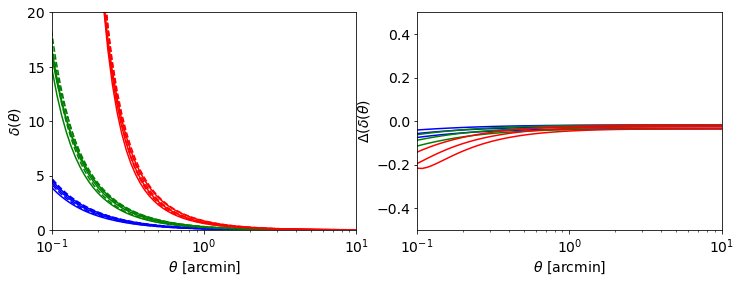

In [146]:
#b,g,b = lowest mass, intermediate mass, high mass

#items = [0,2,4]
items = [2,3,4]

fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True)

[ax[0].plot(Mpc_to_arcmin(rp, z=z_cl[i,0], cosmo=cosmo), model[:,i,0],'b') for i in items]
[ax[0].plot(Mpc_to_arcmin(rp, z=z_cl[i,2], cosmo=cosmo), model[:,i,2],'g') for i in items]
[ax[0].plot(Mpc_to_arcmin(rp, z=z_cl[i,4], cosmo=cosmo), model[:,i,4],'r') for i in items]

#model with approximate mean redshift and source plane approximation
[ax[0].plot(Mpc_to_arcmin(rp, z=z_cl[i,0], cosmo=cosmo), model2[:,i,0],'b--') for i in items]
[ax[0].plot(Mpc_to_arcmin(rp, z=z_cl[i,2], cosmo=cosmo), model2[:,i,2],'g--') for i in items]
[ax[0].plot(Mpc_to_arcmin(rp, z=z_cl[i,4], cosmo=cosmo), model2[:,i,4],'r--') for i in items]


[ax[1].plot(Mpc_to_arcmin(rp, z=z_cl[i,0], cosmo=cosmo), (model[:,i,0] - model2[:,i,0])/model[:,i,0],'b') for i in items]
[ax[1].plot(Mpc_to_arcmin(rp, z=z_cl[i,2], cosmo=cosmo), (model[:,i,2] - model2[:,i,2])/model[:,i,2],'g') for i in items]
[ax[1].plot(Mpc_to_arcmin(rp, z=z_cl[i,4], cosmo=cosmo), (model[:,i,4] - model2[:,i,4])/model[:,i,4],'r') for i in items]


ax[0].set_xlim(0.1, 10)
ax[0].set_xscale('log')

ax[0].set_ylim(0,20)
ax[1].set_ylim(-0.5,0.5)

ax[0].set_xlabel('$\\theta$ [arcmin]')
ax[0].set_ylabel('$\\delta$($\\theta$)')

ax[1].set_xlabel('$\\theta$ [arcmin]')
ax[1].set_ylabel('$\Delta (\\delta$($\\theta$)')

### _=>  Taking an imprecise redshift and using a source plane approximation makes a small difference in the inner part of magnification biais profile_

### - Plot data with predicted model (at mass_mean, z_mean)

In [147]:
def corr_plot(r, xi, sigxi, r_rand, xi_rand, sigxi_rand, fig=None, ax=None, corr=False):
    if fig==None:
        fig, ax = plt.subplots(1,1)
    
    if corr==True:
        sigxi = np.sqrt(np.diag(sigxi))
        sigxi_rand = np.sqrt(np.diag(sigxi_rand))
    
    ax.errorbar(r, xi, yerr= sigxi, color='red', fmt='.')
    ax.fill_between(r_rand, y1= xi_rand - sigxi_rand, y2 = xi_rand + sigxi_rand, color='grey',alpha=0.5)
    ax.grid()
    ax.set_xscale('log')
    ax.set_xlabel(r'$\theta$ (arcmin)')
    ax.set_ylabel(r'$\delta_{\mu}$')
    return fig, ax

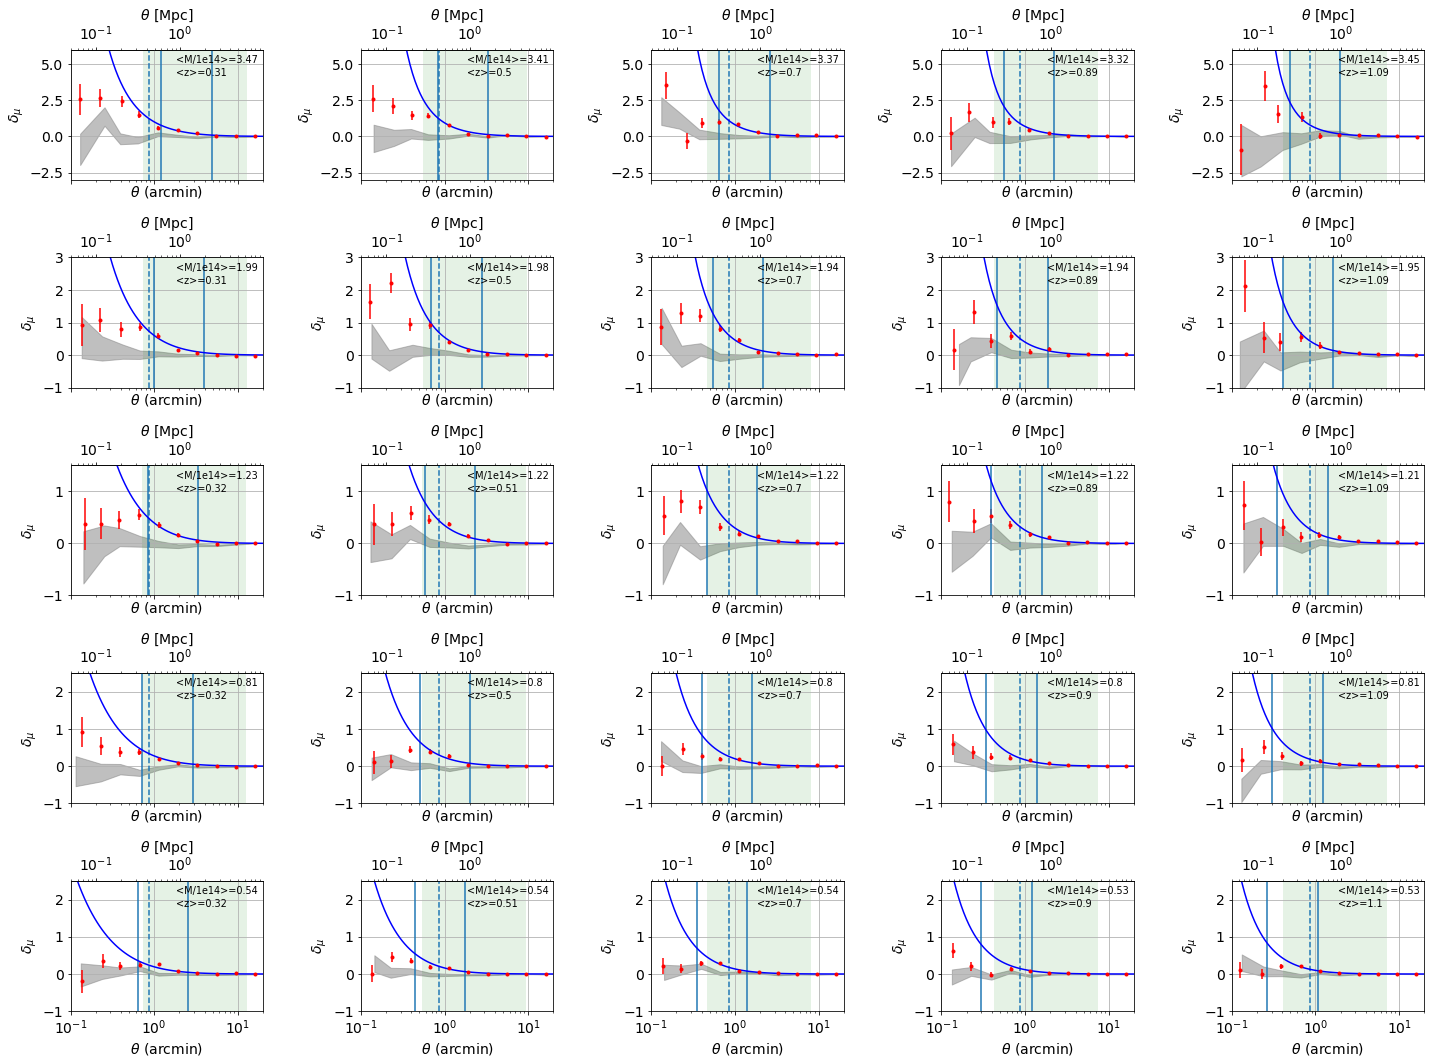

In [148]:

fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)
for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        def func_Mpc_to_arcmin(x_Mpc):
            return Mpc_to_arcmin(x_Mpc, z=z_cl[i,j], cosmo=cosmo)
        
        def func_arcmin_to_Mpc(x_arc):
            return arcmin_to_Mpc(x_arc, z=z_cl[i,j], cosmo=cosmo)
        
        f, ax =  corr_plot(*quant[i,j], fig=fig, ax=axes[5-1-k,h], corr=True)

        ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dashed")
    
        secax = ax.secondary_xaxis('top', functions=(func_arcmin_to_Mpc, func_Mpc_to_arcmin))
        secax.set_xlabel('$\\theta$ [Mpc]')

        r200 = scaled_radius(200, mass_cl[i,j], z_cl[i,j], cosmo)
        ax.axvline(func_Mpc_to_arcmin(r200))
        ax.axvline(func_Mpc_to_arcmin(0.25*r200))

        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
        
        ax.plot(Mpc_to_arcmin(rp, z=z_cl[i,j], cosmo=cosmo), model[:,i,j],'b')
        
        ax.axvspan(func_Mpc_to_arcmin(0.2), func_Mpc_to_arcmin(3.5), color='green', alpha=0.1, lw=0)
        
        
plt.tight_layout()

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(-1,2.5)
    axes[3,i].set_ylim(-1,2.5)
    axes[2,i].set_ylim(-1,1.5)
    axes[1,i].set_ylim(-1,3)
    axes[0,i].set_ylim(-3,6)
    for j in range(axes.shape[1]):
        axes[i,j].set_xlim(0.1,20)

# **Fit the mean halo mass**

### - predict model for a range of masses at z = z_mean

In [149]:
mass_guess = np.logspace(12,16,500, base=10)

In [150]:
fmodel_guess = np.zeros((len(z_cl), len(mass_guess)), dtype=object)
model_guess = np.zeros((rp.size, len(mass_guess), len(z_cl)))

for i in range(len(z_cl)):
    print(i)
    for l in range(len(mass_guess)):
        model_guess[:, l, i] = magnification_biais_model(rp, mass_guess[l], z_cl[i,0], alpha_cut, 2.8, cosmo, cosmo_ccl)
        x = Mpc_to_arcmin(rp, z=z_cl[i,0], cosmo=cosmo)
        fmodel_guess[i, l] = itp.interp1d(x, model_guess[:, l, i])

0


/pbs/throng/lsst/users/mricci/desc/Magnification_project/magnification_library.py:92: RuntimeWarning: invalid value encountered in power
  mu_bias = mu**(beta-1)


1
2
3
4


### - chi2 computation

In [151]:
def sum_chi2(data, error, model, step_low=0, step_high=None, cov=False):
    if step_high==None:
        step_high=len(data)
        
    data = data[step_low:step_high]
    model = model[step_low:step_high]
    if cov==True:
        error = error[step_low:step_high, step_low:step_high]
        y = (data - model).T * np.linalg.inv(error) * (data - model)
    else :
        error = error[step_low:step_high]
        y = (data - model)**2/error**2
    return np.sum(y)

In [163]:
i,j = 0,0
#range to ensure ~ 0.2 to 3.5 Mpc
step_low = np.array([4,3,3,3,3]) +1
step_high = 10 - np.array([-1,-1,-2,-2,-2]) 

chi2_val = np.zeros((z_cl.shape[0], z_cl.shape[1], len(mass_guess)))

for i in range(len(z_cl)):
    for j in range(len(mass_cl)):
        for l in range(len(mass_guess)):
            chi2_val[i,j,l] = sum_chi2(quant[i,j][1], quant[i,j][2], fmodel_guess[i,l](quant[i,j][0]), step_low[i], step_high[i], cov=True)

### - mass fitting : chi2 minimization

In [164]:
def mass_minimization(chi2_val, mass_guess, s = np.array([1.,2.,3.]) ):
    
    if np.sum(np.isnan(chi2_val))==len(mass_guess):
        print('Chi2val contains only nan!')
        eval_mass, eval_mass_min, eval_mass_max, nanarg = np.nan, np.nan, np.nan, np.nan
    else:
        nanarg = np.nanargmin(chi2_val)
        chi2_val_itp_up = itp.interp1d(chi2_val[nanarg :], mass_guess[nanarg :], bounds_error= False)
        chi2_val_itp_low = itp.interp1d(chi2_val[: nanarg + 1], mass_guess[: nanarg + 1], bounds_error= False)

        chi2_eval = stats.chi2.ppf(stats.chi2.cdf(s**2,1), 1)

        eval_mass = mass_guess[np.nanargmin(chi2_val)]
        eval_mass_min = chi2_val_itp_low(np.nanmin(chi2_val) + stats.chi2.ppf(stats.chi2.cdf(s**2,1), 1))
        eval_mass_max = chi2_val_itp_up(np.nanmin(chi2_val)  + stats.chi2.ppf(stats.chi2.cdf(s**2,1), 1))

    return eval_mass, eval_mass_min, eval_mass_max, nanarg

In [165]:
mass_eval = np.zeros((z_cl.shape))
mass_min = np.zeros((z_cl.shape))
mass_max = np.zeros((z_cl.shape))
ind = np.zeros((z_cl.shape))

for i in range(z_cl.shape[0]):
    for j in range(z_cl.shape[1]):
    #eval_mass, eval_mass_min, eval_mass_max 
        mass_eval[i,j], mass_min[i,j], mass_max[i,j], ind[i,j] = mass_minimization(chi2_val[i,j,:], mass_guess, s=1.)
        #print("True mass", mass[i,j]/1e13)
        #print( "evaluated mass =, %1.2e" % results[i,j][0])
        #[print ("sigma =", np.array([1.,2.,3.])[i], ", min mass =", "%1.2e" % eval_mass_min[i], ", max mass =", "%1.2e" % eval_mass_max[i]) for i in range(3)];

### - mass estimates checking

/pbs/throng/lsst/software/desc/common/miniconda/py3.7-4.7.12.1-v2/envs/desc/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


Text(0.5, 0, 'mass eval [Msun]')

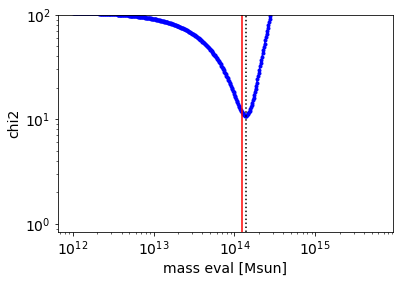

In [166]:
i,j=1,2

plt.plot(mass_guess, chi2_val[i,j,:],'b.-')

plt.xscale('log')
plt.yscale('log')

plt.axvline(mass_cl[i,j], color='red')
plt.axhline(np.min(chi2_val[i,j,:]),  color='black', alpha=1,linestyle="dotted")
plt.axvline(mass_eval[i,j],  color='black', alpha=1,linestyle="dotted")

[plt.axhline(np.min(chi2_val[i,j,:]) + u ) for u in stats.chi2.ppf(stats.chi2.cdf( np.array([1.,2.,3.])**2,1), 1)];

#[plt.axvline(mass_min[i,j][i], alpha=0.5) for i in range(3)];
#[plt.axvline(mass_max[i,j][i], alpha=0.5) for i in range(3)];


plt.ylim(0,100)

plt.ylabel("chi2")
plt.xlabel("mass eval [Msun]")

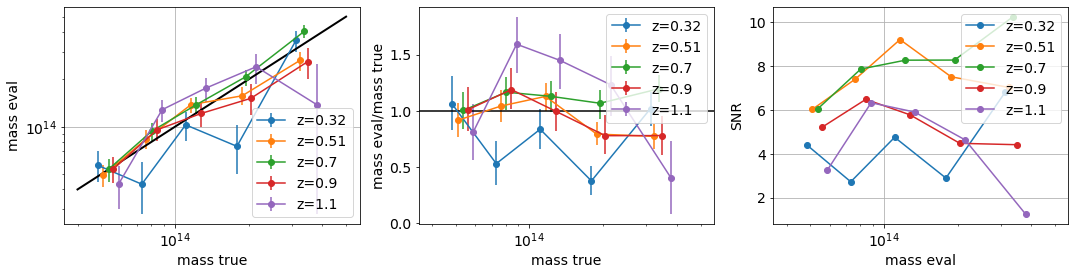

In [167]:
#step = 3

fig, ax = plt.subplots(1, 3, figsize=(18,4), sharex=True)

ax[0].errorbar(mass_cl[0,:]*0.90, mass_eval[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:]),fmt='-o', label ="z="+str(round(z_cl[0,0],2)))
ax[0].errorbar(mass_cl[1,:]*0.95, mass_eval[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:]),fmt='-o', label ="z="+str(round(z_cl[1,0],2)))
ax[0].errorbar(mass_cl[2,:]*1.00, mass_eval[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:]),fmt='-o', label ="z="+str(round(z_cl[2,0],2)))
ax[0].errorbar(mass_cl[3,:]*1.05, mass_eval[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:]),fmt='-o', label ="z="+str(round(z_cl[3,0],2)))
ax[0].errorbar(mass_cl[4,:]*1.10, mass_eval[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:]),fmt='-o', label ="z="+str(round(z_cl[4,0],2)))

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].plot((4e13, 5e14),(4e13,5e14), color='black', lw=2)
ax[0].legend()
ax[0].set_xlabel("mass true")
ax[0].set_ylabel("mass eval")
ax[0].grid()

ax[1].errorbar(mass_cl[0,:]*0.90, mass_eval[0,:]/mass_cl[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:])/mass_cl[0,:],fmt='-o', label ="z="+str(round(z_cl[0,0],2)))
ax[1].errorbar(mass_cl[1,:]*0.95, mass_eval[1,:]/mass_cl[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:])/mass_cl[1,:],fmt='-o', label ="z="+str(round(z_cl[1,0],2)))
ax[1].errorbar(mass_cl[2,:]*1.00, mass_eval[2,:]/mass_cl[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:])/mass_cl[2,:],fmt='-o', label ="z="+str(round(z_cl[2,0],2)))
ax[1].errorbar(mass_cl[3,:]*1.05, mass_eval[3,:]/mass_cl[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:])/mass_cl[3,:],fmt='-o', label ="z="+str(round(z_cl[3,0],2)))
ax[1].errorbar(mass_cl[4,:]*1.10, mass_eval[4,:]/mass_cl[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:])/mass_cl[4,:],fmt='-o', label ="z="+str(round(z_cl[4,0],2)))

ax[1].set_xscale('log')
ax[1].axhline(1, color='black')
ax[1].legend()
ax[1].set_xlabel("mass true")
ax[1].set_ylabel("mass eval/mass true")


ax[2].plot(mass_cl[0,:]*0.90, mass_eval[0,:]/(0.5*(mass_max[0,:] - mass_min[0,:])),'-o', label ="z="+str(round(z_cl[0,0],2)))
ax[2].plot(mass_cl[1,:]*0.95, mass_eval[1,:]/(0.5*(mass_max[1,:] - mass_min[1,:])),'-o', label ="z="+str(round(z_cl[1,0],2)))
ax[2].plot(mass_cl[2,:]*1.00, mass_eval[2,:]/(0.5*(mass_max[2,:] - mass_min[2,:])),'-o', label ="z="+str(round(z_cl[2,0],2)))
ax[2].plot(mass_cl[3,:]*1.05, mass_eval[3,:]/(0.5*(mass_max[3,:] - mass_min[3,:])),'-o', label ="z="+str(round(z_cl[3,0],2)))
ax[2].plot(mass_cl[4,:]*1.10, mass_eval[4,:]/(0.5*(mass_max[4,:] - mass_min[4,:])),'-o', label ="z="+str(round(z_cl[4,0],2)))

ax[2].set_xscale('log')
ax[2].legend()
ax[2].set_ylabel("SNR")
ax[2].set_xlabel("mass eval")
ax[2].grid()

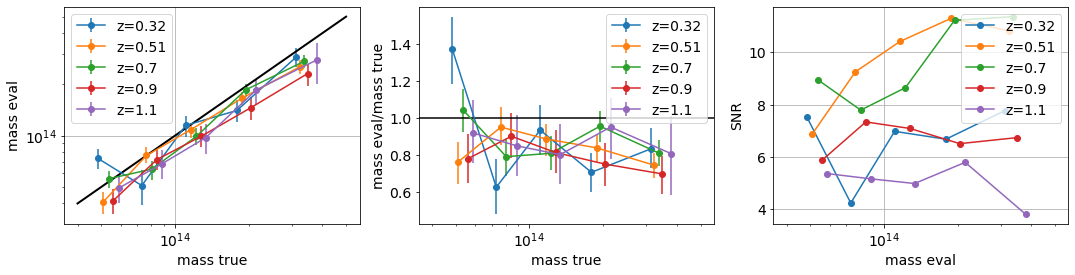

In [162]:
#step = 3

fig, ax = plt.subplots(1, 3, figsize=(18,4), sharex=True)

ax[0].errorbar(mass_cl[0,:]*0.90, mass_eval[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:]),fmt='-o', label ="z="+str(round(z_cl[0,0],2)))
ax[0].errorbar(mass_cl[1,:]*0.95, mass_eval[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:]),fmt='-o', label ="z="+str(round(z_cl[1,0],2)))
ax[0].errorbar(mass_cl[2,:]*1.00, mass_eval[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:]),fmt='-o', label ="z="+str(round(z_cl[2,0],2)))
ax[0].errorbar(mass_cl[3,:]*1.05, mass_eval[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:]),fmt='-o', label ="z="+str(round(z_cl[3,0],2)))
ax[0].errorbar(mass_cl[4,:]*1.10, mass_eval[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:]),fmt='-o', label ="z="+str(round(z_cl[4,0],2)))

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].plot((4e13, 5e14),(4e13,5e14), color='black', lw=2)
ax[0].legend()
ax[0].set_xlabel("mass true")
ax[0].set_ylabel("mass eval")
ax[0].grid()

ax[1].errorbar(mass_cl[0,:]*0.90, mass_eval[0,:]/mass_cl[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:])/mass_cl[0,:],fmt='-o', label ="z="+str(round(z_cl[0,0],2)))
ax[1].errorbar(mass_cl[1,:]*0.95, mass_eval[1,:]/mass_cl[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:])/mass_cl[1,:],fmt='-o', label ="z="+str(round(z_cl[1,0],2)))
ax[1].errorbar(mass_cl[2,:]*1.00, mass_eval[2,:]/mass_cl[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:])/mass_cl[2,:],fmt='-o', label ="z="+str(round(z_cl[2,0],2)))
ax[1].errorbar(mass_cl[3,:]*1.05, mass_eval[3,:]/mass_cl[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:])/mass_cl[3,:],fmt='-o', label ="z="+str(round(z_cl[3,0],2)))
ax[1].errorbar(mass_cl[4,:]*1.10, mass_eval[4,:]/mass_cl[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:])/mass_cl[4,:],fmt='-o', label ="z="+str(round(z_cl[4,0],2)))

ax[1].set_xscale('log')
ax[1].axhline(1, color='black')
ax[1].legend()
ax[1].set_xlabel("mass true")
ax[1].set_ylabel("mass eval/mass true")


ax[2].plot(mass_cl[0,:]*0.90, mass_eval[0,:]/(0.5*(mass_max[0,:] - mass_min[0,:])),'-o', label ="z="+str(round(z_cl[0,0],2)))
ax[2].plot(mass_cl[1,:]*0.95, mass_eval[1,:]/(0.5*(mass_max[1,:] - mass_min[1,:])),'-o', label ="z="+str(round(z_cl[1,0],2)))
ax[2].plot(mass_cl[2,:]*1.00, mass_eval[2,:]/(0.5*(mass_max[2,:] - mass_min[2,:])),'-o', label ="z="+str(round(z_cl[2,0],2)))
ax[2].plot(mass_cl[3,:]*1.05, mass_eval[3,:]/(0.5*(mass_max[3,:] - mass_min[3,:])),'-o', label ="z="+str(round(z_cl[3,0],2)))
ax[2].plot(mass_cl[4,:]*1.10, mass_eval[4,:]/(0.5*(mass_max[4,:] - mass_min[4,:])),'-o', label ="z="+str(round(z_cl[4,0],2)))

ax[2].set_xscale('log')
ax[2].legend()
ax[2].set_ylabel("SNR")
ax[2].set_xlabel("mass eval")
ax[2].grid()

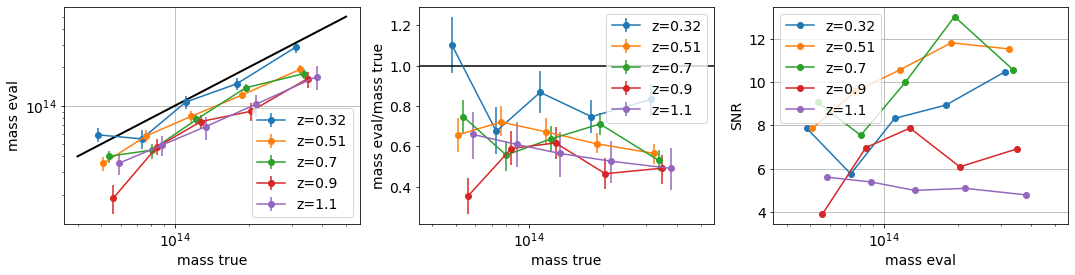

In [156]:
#step = 3

fig, ax = plt.subplots(1, 3, figsize=(18,4), sharex=True)

ax[0].errorbar(mass_cl[0,:]*0.90, mass_eval[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:]),fmt='-o', label ="z="+str(round(z_cl[0,0],2)))
ax[0].errorbar(mass_cl[1,:]*0.95, mass_eval[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:]),fmt='-o', label ="z="+str(round(z_cl[1,0],2)))
ax[0].errorbar(mass_cl[2,:]*1.00, mass_eval[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:]),fmt='-o', label ="z="+str(round(z_cl[2,0],2)))
ax[0].errorbar(mass_cl[3,:]*1.05, mass_eval[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:]),fmt='-o', label ="z="+str(round(z_cl[3,0],2)))
ax[0].errorbar(mass_cl[4,:]*1.10, mass_eval[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:]),fmt='-o', label ="z="+str(round(z_cl[4,0],2)))

ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].plot((4e13, 5e14),(4e13,5e14), color='black', lw=2)
ax[0].legend()
ax[0].set_xlabel("mass true")
ax[0].set_ylabel("mass eval")
ax[0].grid()

ax[1].errorbar(mass_cl[0,:]*0.90, mass_eval[0,:]/mass_cl[0,:],\
             yerr = (mass_eval[0,:] - mass_min[0,:], mass_max[0,:] - mass_eval[0,:])/mass_cl[0,:],fmt='-o', label ="z="+str(round(z_cl[0,0],2)))
ax[1].errorbar(mass_cl[1,:]*0.95, mass_eval[1,:]/mass_cl[1,:],\
             yerr = (mass_eval[1,:] - mass_min[1,:], mass_max[1,:] - mass_eval[1,:])/mass_cl[1,:],fmt='-o', label ="z="+str(round(z_cl[1,0],2)))
ax[1].errorbar(mass_cl[2,:]*1.00, mass_eval[2,:]/mass_cl[2,:],\
             yerr = (mass_eval[2,:] - mass_min[2,:], mass_max[2,:] - mass_eval[2,:])/mass_cl[2,:],fmt='-o', label ="z="+str(round(z_cl[2,0],2)))
ax[1].errorbar(mass_cl[3,:]*1.05, mass_eval[3,:]/mass_cl[3,:],\
             yerr = (mass_eval[3,:] - mass_min[3,:], mass_max[3,:] - mass_eval[3,:])/mass_cl[3,:],fmt='-o', label ="z="+str(round(z_cl[3,0],2)))
ax[1].errorbar(mass_cl[4,:]*1.10, mass_eval[4,:]/mass_cl[4,:],\
             yerr = (mass_eval[4,:] - mass_min[4,:], mass_max[4,:] - mass_eval[4,:])/mass_cl[4,:],fmt='-o', label ="z="+str(round(z_cl[4,0],2)))

ax[1].set_xscale('log')
ax[1].axhline(1, color='black')
ax[1].legend()
ax[1].set_xlabel("mass true")
ax[1].set_ylabel("mass eval/mass true")


ax[2].plot(mass_cl[0,:]*0.90, mass_eval[0,:]/(0.5*(mass_max[0,:] - mass_min[0,:])),'-o', label ="z="+str(round(z_cl[0,0],2)))
ax[2].plot(mass_cl[1,:]*0.95, mass_eval[1,:]/(0.5*(mass_max[1,:] - mass_min[1,:])),'-o', label ="z="+str(round(z_cl[1,0],2)))
ax[2].plot(mass_cl[2,:]*1.00, mass_eval[2,:]/(0.5*(mass_max[2,:] - mass_min[2,:])),'-o', label ="z="+str(round(z_cl[2,0],2)))
ax[2].plot(mass_cl[3,:]*1.05, mass_eval[3,:]/(0.5*(mass_max[3,:] - mass_min[3,:])),'-o', label ="z="+str(round(z_cl[3,0],2)))
ax[2].plot(mass_cl[4,:]*1.10, mass_eval[4,:]/(0.5*(mass_max[4,:] - mass_min[4,:])),'-o', label ="z="+str(round(z_cl[4,0],2)))

ax[2].set_xscale('log')
ax[2].legend()
ax[2].set_ylabel("SNR")
ax[2].set_xlabel("mass eval")
ax[2].grid()

### - plot data, expected model + fitted model

In [ ]:
fig, axes = plt.subplots(5,5, figsize=[20,15], sharex=True)
for i,h in zip([0,1,2,3,4],range(5)):
    for j,k in zip([0,1,2,3,4],range(5)):
        
        def func_Mpc_to_arcmin(x_Mpc):
            return Mpc_to_arcmin(x_Mpc, z=z_cl[i,j], cosmo=cosmo)
        
        def func_arcmin_to_Mpc(x_arc):
            return arcmin_to_Mpc(x_arc, z=z_cl[i,j], cosmo=cosmo)
        
        f, ax =  corr_plot(*quant[i,j], fig=fig, ax=axes[5-1-k,h], corr=True)

        ax.axvline(1*healpy.nside2resol(4096, arcmin = True), linestyle="dashed")
    
        secax = ax.secondary_xaxis('top', functions=(func_arcmin_to_Mpc, func_Mpc_to_arcmin))
        secax.set_xlabel('$\\theta$ [Mpc]')

        r200 = scaled_radius(200, mass_cl[i,j], z_cl[i,j], cosmo)
        ax.axvline(func_Mpc_to_arcmin(r200))
        ax.axvline(func_Mpc_to_arcmin(0.25*r200))

        ax.text(0.55, 0.80, "<z>="+str(round(z_cl[i,j],2)), transform=ax.transAxes, fontsize='x-small')
        ax.text(0.55, 0.90, "<M/1e14>="+str(round(mass_cl[i,j]/1e14,2)), transform=ax.transAxes, fontsize='x-small');
        
        ax.plot(Mpc_to_arcmin(rp, z=z_cl[i,j], cosmo=cosmo), model[:,j,i],'b')
        ax.plot(Mpc_to_arcmin(rp, z=z_cl[i,0], cosmo=cosmo), model_guess[:,int(ind[i,j]), i],'r')
        
        ax.axvspan(func_Mpc_to_arcmin(0.2), func_Mpc_to_arcmin(3.5), color='green', alpha=0.1, lw=0)
        
        
plt.tight_layout()

for i in range(axes.shape[0]):
    axes[4,i].set_ylim(-1,2.5)
    axes[3,i].set_ylim(-1,2.5)
    axes[2,i].set_ylim(-1,1.5)
    axes[1,i].set_ylim(-1,3)
    axes[0,i].set_ylim(-3,6)
    for j in range(axes.shape[1]):
        axes[i,j].set_xlim(0.1,20)